In [6178]:
import pandas as pd
import numpy as np
from torch import nn

In [7404]:
# converting strings to lists of ints
def to_list(str):
    string = str.replace('[','').replace(']','')
    ls = string.split(',')
    list = [int(i) for i in ls]
    return list

In [7405]:
def process(eval):
    sum = 3
    i = 0
    res = []
    for cpl in eval:
        if i % 2 ==0:
            res.append([sum,cpl])
            sum -= cpl
            i += 1
        else:
            sum+=cpl
            i+=1
    return np.array(res)

In [7406]:
# reading *some* of the data
dfs = []

players = ['andreikin, dmitry', 'anand, viswanathan', 'wang, hao', 'grischuk, alexander', 'karjakin, sergey','duda, jan-krzysztof', 'radjabov, teimour', 'dominguez perez, leinier','nakamura, hikaru', 'vachier-lagrave, maxime','aronian, levon','mamedyarov, shakhriyar', 'so, wesley','ding, liren', 'rapport, richard', 'nepomniachtchi, ian', 'giri, anish', 'firouzja, alireza', 'caruana, fabiano','carlsen, magnus','zelcic, robert','khotenashvili, bela', 'bischoff, klaus']

for player in players:
    df = pd.read_csv('blitz/'+player +'.csv')
    dfs.append(df)
df = pd.concat(dfs)

#df = df.dropna()
print(len(df))
df = df[df['WhiteELO'] != '*']
df = df[df['BlackELO'] != '*']
df[['WhiteELO', 'BlackELO']] = df[['WhiteELO', 'BlackELO']] .astype(int)

df = df[df['Eval'] != '']
df = df[ df['Eval'].apply(lambda x: isinstance(x, str))]

df['Eval'] = df['Eval'].apply( to_list)
df['Eval'] = df['Eval'].apply( process )

# making ragged tensors from my data
y_train = list(df['BlackELO'][:40])

5697


In [7407]:
print(df['Eval'])

3       [[3, 34], [11, 35], [13, 36], [-3, 17], [-4, 1...
6       [[3, 46], [-9, 35], [-13, 35], [-12, 35], [-10...
10      [[3, 31], [7, 43], [3, 34], [-11, 22], [-6, 22...
17      [[3, 44], [-10, 42], [-13, 64], [-20, 53], [-1...
26      [[3, 19], [-4, 27], [-22, 12], [-29, 21], [-34...
                              ...                        
1497    [[3, 35], [-13, 45], [-51, 17], [-57, 24], [-7...
1502    [[3, 48], [-7, 68], [-10, 70], [-7, 98], [-41,...
1522    [[3, 47], [-2, 50], [-11, 58], [-23, 60], [-41...
1532    [[3, 39], [-10, 33], [-19, 41], [-20, 38], [-1...
1541    [[3, 0], [-34, -10], [-38, -6], [-43, 7], [-71...
Name: Eval, Length: 574, dtype: object


In [7408]:
x = np.array(df['Eval'])

In [7409]:
print(len(df['Eval'][8]))

37


In [7410]:
length = np.array(df['Eval'].apply(len))
print(length)

[ 57  26  29  56  40  55  63  24  46  26  45  48  29  85  60  31  48  34
  37  35   9  41  84  84  59  46  45  36  53  41  31  52  46 105  46  60
  33  24  28  32  78  25  24  52  57  61  70  57  55  28  43  41  39  33
  67  36  69  36  32  22  41  62   6  13  36  35  60  79  29  53   5  56
  22  47  55  32   9  61  36  75  50  48  22  28  94  49  22  33  26  26
  35  43  57  42  67  40  45  59  25  49  42  32  18  32  30  36  64  47
  46  34  38  50  36  58  14  28  40  27  30  52  44  22  56  30  21  51
  68  24  31  53  59  37  35  33  33  42  36  22  60  55  34  54  65  51
  55  42  59  35  98  83  41  31  37  37  60  27  43  39  67  27  30  34
  56  58  30  37  48  39  42  33  29  46  88  79  41  67  84  56  41  37
  48  59  30  50  33  61  36  26  58  30  50  44  34  41  25  23  24  75
  18  46  43  43  46  23  30  39  19  56  39  56  23  28  38  36  33  47
  52  29  43  27  39  35  32  51  36  43  57  49  48  20  33 108  46  34
  32  58  54  71  62  35  49  42  45  55  65  39  3

In [7411]:
from sklearn.preprocessing import PowerTransformer

In [7412]:
pt = PowerTransformer()

In [7413]:
y = np.concatenate(x)
print(y.shape)

(24662, 2)


In [7414]:
pt.fit(y)

PowerTransformer()

In [7415]:
transformed = pt.transform(y)

In [7416]:
print(transformed)

[[ 0.62086462 -0.06061415]
 [ 0.6323967  -0.05900016]
 [ 0.6353814  -0.05738528]
 ...
 [ 0.21029095  2.45260779]
 [ 0.35655828  4.26875204]
 [ 0.33746879 -0.11451841]]


In [7417]:
from itertools import islice

In [7418]:
# need a function now to (effieciently) change these to lists of length list
transformed_array = [np.array(list(islice(iter(transformed), elem)))
        for elem in length]

In [7419]:
print(transformed_array)

[array([[ 6.20864623e-01, -6.06141504e-02],
       [ 6.32396702e-01, -5.90001567e-02],
       [ 6.35381396e-01, -5.73852763e-02],
       [ 6.13286534e-01, -8.78845571e-02],
       [ 6.12144512e-01, -8.62912298e-02],
       [ 5.92962745e-01, -8.62912298e-02],
       [ 5.82834586e-01, -9.74037430e-02],
       [ 5.71926133e-01, -9.42392922e-02],
       [ 5.64108255e-01, -9.74037430e-02],
       [ 5.63136844e-01, -7.99021022e-02],
       [ 5.51567713e-01, -6.54505555e-02],
       [ 5.33527683e-01, -4.92983551e-02],
       [ 5.16686125e-01, -1.02462462e-02],
       [ 5.13899187e-01,  5.37920300e-02],
       [ 4.63603555e-01, -2.33011559e-02],
       [ 4.12686480e-01, -7.02779918e-02],
       [ 3.88012573e-01,  2.41639280e-02],
       [ 3.44399510e-01, -7.83012197e-02],
       [ 3.53080361e-01,  6.11613734e-03],
       [ 3.43532501e-01,  2.74503733e-02],
       [ 2.76451103e-01, -9.89821586e-02],
       [ 2.92698492e-01, -4.34262943e-04],
       [ 2.45813054e-01, -1.51457223e-02],
       [ 2

In [7420]:
#padded = (df['Eval'].apply(lambda x: x + [0]*(length - len(x))))
#print(df['Eval'])

In [7421]:
#print(padded)

In [7422]:
#mean = padded.mean()
#std = np.linalg.norm(padded)

In [7423]:
#df['Eval'] = df['Eval'].apply(lambda x: (np.array(x) - mean)/std )
#df['Eval'] = df['Eval'].apply( process )

In [7424]:
print(lengths)

[57, 26, 29, 56, 40, 55, 63, 24, 46, 26, 45, 48, 29, 85, 60, 31, 48, 34, 37, 35, 9, 41, 84, 84, 59, 46, 45, 36, 53, 41, 31, 52, 46, 105, 46, 60, 33, 24, 28, 32, 78, 25, 24, 52, 57, 61, 70, 57, 55, 28, 43, 41, 39, 33, 67, 36, 69, 36, 32, 22, 41, 62, 6, 13, 36, 35, 60, 79, 29, 53, 5, 56, 22, 47, 55, 32, 9, 61, 36, 75, 50, 48, 22, 28, 94, 49, 22, 33, 26, 26, 35, 43, 57, 42, 67, 40, 45, 59, 25, 49, 42, 32, 18, 32, 30, 36, 64, 47, 46, 34, 38, 50, 36, 58, 14, 28, 40, 27, 30, 52, 44, 22, 56, 30, 21, 51, 68, 24, 31, 53, 59, 37, 35, 33, 33, 42, 36, 22, 60, 55, 34, 54, 65, 51, 55, 42, 59, 35, 98, 83, 41, 31, 37, 37, 60, 27, 43, 39, 67, 27, 30, 34, 56, 58, 30, 37, 48, 39, 42, 33, 29, 46, 88, 79, 41, 67, 84, 56, 41, 37, 48, 59, 30, 50, 33, 61, 36, 26, 58, 30, 50, 44, 34, 41, 25, 23, 24, 75, 18, 46, 43, 43, 46, 23, 30, 39, 19, 56, 39, 56, 23, 28, 38, 36, 33, 47, 52, 29, 43, 27, 39, 35, 32, 51, 36, 43, 57, 49, 48, 20, 33, 108, 46, 34, 32, 58, 54, 71, 62, 35, 49, 42, 45, 55, 65, 39, 37, 61, 40, 56, 4

In [7425]:
print(df['Game'].nunique())

569


# Using PyTorch

In [7426]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split

In [7427]:
# next we would need to update the weights, and repeat

In [7428]:
X = np.array

In [7429]:
evals = np.array(df['Eval'])

In [7430]:
evals = [torch.tensor(i, dtype = torch.float32) for i in evals]
evals = [torch.tensor(i, dtype = torch.float32) for i in transformed_array]

In [7431]:
lengths = [len(tensor) for tensor in evals]

In [7432]:
# Padding my sequences - not sure why batch first works, but it does
inputs = torch.nn.utils.rnn.pad_sequence(evals, batch_first=True, padding_value=0.0)

In [7433]:
inputs_array = np.array(inputs.tolist())

In [7434]:
print(inputs.shape)

torch.Size([574, 117, 2])


In [7435]:
inputs_list =inputs.tolist()

# normalizing... a bit hacky
#inputs_array = (np.array(inputs_list) - np.array(inputs_list).mean())/ np.linalg.norm(np.array(inputs_list))

In [7436]:
def normalize(array):
    return (array - array.mean())/array.std()

def denormalize(array, value):
    return value*array.std() + array.mean()

In [7437]:
print(df['WhiteELO'].value_counts())

2725    33
2726    21
2736    16
2705    15
2720    15
        ..
2565     1
2578     1
2548     1
2471     1
2331     1
Name: WhiteELO, Length: 218, dtype: int64


In [7438]:
# Converting White and Black's ELOs to tensors
white_elo_arr = np.array(df['WhiteELO'])

white_elo = normalize(white_elo_arr)

#print(white_elo)
white_elo = [torch.tensor(i, dtype = torch.float32) for i in white_elo]



black_elo = np.array(df['BlackELO'])
black_elo = [torch.tensor(i, dtype = torch.float32) for i in black_elo]


# splitting into train and test
lengths_train, lengths_test,eval_train, eval_test, black_train, black_test, white_train, white_test  = train_test_split(lengths, evals, black_elo, white_elo, test_size=0.2,random_state=0, shuffle = True)


## But how do I use the packed sequence

In [7439]:
black_elo = torch.stack(black_elo)
white_elo = torch.stack(white_elo)

In [7440]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers, batch_size):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        self.rnn = nn.RNN(input_size, hidden_size, no_layers, batch_first = True, bias = True)
        self.fc = nn.Linear(hidden_size,1, bias = False)
        self.final = nn.Tanh()

    def forward(self, x):
        t, l = torch.nn.utils.rnn.pad_packed_sequence(x)

        # initial hidden state
        #h0 = torch.rand(self.no_layers,batch_size,self.hidden_size)

        out, _ = self.rnn(x)


        # shape batches, seq_length, hidden_size
        output ,lengths = torch.nn.utils.rnn.pad_packed_sequence(out, batch_first = True)

        out = [output[e, i-1,:].unsqueeze(0) for e, i in enumerate(lengths)]

        out = torch.cat(out, dim = 0)
        #print(out.shape)
        #print("Linear weights", self.fc.weight)


        out = self.fc(out)
        out = self.final(out)
        #print(out.shape)

        return out[:,0]


    #def init_hidden(self):
    #    return nn.init.kaiming_uniform_(torch.empty(1, self.hidden_size))

# need to figure out exactly how the dimensions changed


In [7441]:
input_size = 2
hidden_size = 10
no_layers = 3
batch_size =4

In [7442]:
model = MyRNN(input_size, hidden_size, no_layers, batch_size)

In [7443]:
model.parameters()

<generator object Module.parameters at 0x00000170B64136F0>

In [7444]:
for name, param in model.named_parameters():
    print('name: ', name)
    print(type(param))
    print('param.shape: ', param.shape)
    print('param.requires_grad: ', param.requires_grad)
    print('=====')

name:  rnn.weight_ih_l0
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10, 2])
param.requires_grad:  True
=====
name:  rnn.weight_hh_l0
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10, 10])
param.requires_grad:  True
=====
name:  rnn.bias_ih_l0
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10])
param.requires_grad:  True
=====
name:  rnn.bias_hh_l0
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10])
param.requires_grad:  True
=====
name:  rnn.weight_ih_l1
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10, 10])
param.requires_grad:  True
=====
name:  rnn.weight_hh_l1
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10, 10])
param.requires_grad:  True
=====
name:  rnn.bias_ih_l1
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10])
param.requires_grad:  True
=====
name:  rnn.bias_hh_l1
<class 'torch.nn.parameter.Parameter'>
param.shape:  torch.Size([10])
param.requ

In [7445]:
print(eval_train)

[tensor([[ 6.2086e-01, -6.0614e-02],
        [ 6.3240e-01, -5.9000e-02],
        [ 6.3538e-01, -5.7385e-02],
        [ 6.1329e-01, -8.7885e-02],
        [ 6.1214e-01, -8.6291e-02],
        [ 5.9296e-01, -8.6291e-02],
        [ 5.8283e-01, -9.7404e-02],
        [ 5.7193e-01, -9.4239e-02],
        [ 5.6411e-01, -9.7404e-02],
        [ 5.6314e-01, -7.9902e-02],
        [ 5.5157e-01, -6.5451e-02],
        [ 5.3353e-01, -4.9298e-02],
        [ 5.1669e-01, -1.0246e-02],
        [ 5.1390e-01,  5.3792e-02],
        [ 4.6360e-01, -2.3301e-02],
        [ 4.1269e-01, -7.0278e-02],
        [ 3.8801e-01,  2.4164e-02],
        [ 3.4440e-01, -7.8301e-02],
        [ 3.5308e-01,  6.1161e-03],
        [ 3.4353e-01,  2.7450e-02],
        [ 2.7645e-01, -9.8982e-02],
        [ 2.9270e-01, -4.3426e-04],
        [ 2.4581e-01, -1.5146e-02],
        [ 2.3056e-01, -1.1880e-02],
        [ 1.3488e-01, -2.0205e-01],
        [ 1.3488e-01, -9.4239e-02],
        [ 1.3238e-01, -1.0683e-01],
        [ 1.2822e-01, -1.14

In [7446]:
eval_train = [torch.tensor(i, dtype = torch.float32) for i in eval_train]
white_train = [torch.tensor(i, dtype = torch.float32) for i in white_train]

#eval_train = torch.stack(eval_train)
#white_train = torch.stack(white_train)

train_data = list(zip(evals_packed, white_train))
train_data_zip = list(zip(eval_train, white_train))

#eval_test = [torch.tensor(i, dtype=torch.float32) for i in eval_test]
#white_test = [torch.tensor(i, dtype=torch.float32) for i in white_test]

#eval_test = torch.stack(eval_test)
#white_test = torch.stack(white_test)

#test_data_zip = list(zip(eval_test, white_test))
# not sure why I'm seeing a warning...

C:\Users\Administrator\AppData\Local\Temp\ipykernel_2580\1595150946.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eval_train = [torch.tensor(i, dtype = torch.float32) for i in eval_train]
C:\Users\Administrator\AppData\Local\Temp\ipykernel_2580\1595150946.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  white_train = [torch.tensor(i, dtype = torch.float32) for i in white_train]


In [7447]:
print(train_data_zip)

[(tensor([[ 6.2086e-01, -6.0614e-02],
        [ 6.3240e-01, -5.9000e-02],
        [ 6.3538e-01, -5.7385e-02],
        [ 6.1329e-01, -8.7885e-02],
        [ 6.1214e-01, -8.6291e-02],
        [ 5.9296e-01, -8.6291e-02],
        [ 5.8283e-01, -9.7404e-02],
        [ 5.7193e-01, -9.4239e-02],
        [ 5.6411e-01, -9.7404e-02],
        [ 5.6314e-01, -7.9902e-02],
        [ 5.5157e-01, -6.5451e-02],
        [ 5.3353e-01, -4.9298e-02],
        [ 5.1669e-01, -1.0246e-02],
        [ 5.1390e-01,  5.3792e-02],
        [ 4.6360e-01, -2.3301e-02],
        [ 4.1269e-01, -7.0278e-02],
        [ 3.8801e-01,  2.4164e-02],
        [ 3.4440e-01, -7.8301e-02],
        [ 3.5308e-01,  6.1161e-03],
        [ 3.4353e-01,  2.7450e-02],
        [ 2.7645e-01, -9.8982e-02],
        [ 2.9270e-01, -4.3426e-04],
        [ 2.4581e-01, -1.5146e-02],
        [ 2.3056e-01, -1.1880e-02],
        [ 1.3488e-01, -2.0205e-01],
        [ 1.3488e-01, -9.4239e-02],
        [ 1.3238e-01, -1.0683e-01],
        [ 1.2822e-01, -1.1

In [7448]:
# train_data is not what I expected.

In [7449]:
my_ldr = torch.utils.data.DataLoader(train_data, 4)

In [7450]:
print(model.parameters)

<bound method Module.parameters of MyRNN(
  (rnn): RNN(2, 10, num_layers=3, batch_first=True)
  (fc): Linear(in_features=10, out_features=1, bias=False)
  (final): Tanh()
)>


In [7451]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [7452]:
class MyCollator(object):
    '''
    Yields a batch from a list of Items
    Args:
    test : Set True when using with test data loader. Defaults to False
    percentile : Trim sequences by this percentile
    '''

    # remove that eventually. I'm going to need to make my dataset a tuple with evals and elo
    #def __init__(self):

    def __call__(self, batch):
        data = [item[0] for item in batch]
        target = [item[1] for item in batch]
        lens = [i.shape[0] for i in data]

        #print(lens)
        data = torch.nn.utils.rnn.pad_sequence(data, batch_first=True,padding_value = 0)
        #data = data.unsqueeze(2)
        #print("PADDED",data)
        evals_packed = torch.nn.utils.rnn.pack_padded_sequence(data,batch_first = True, lengths=lens,enforce_sorted=False)

        target = torch.tensor(target,dtype=torch.float32)
        return [evals_packed,target]

In [7453]:
collate = MyCollator()

In [7454]:
data_loader = torch.utils.data.DataLoader(train_data_zip, batch_size=batch_size, shuffle=True ,collate_fn=collate)

In [7455]:
import statistics as s

In [7456]:
learning_rate = .01

In [7457]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

In [7458]:
# OK I've figured out the issue, I also need the sequence length for the RNN

In [7460]:
avg_losses = []
epochs = []
for epoch in range(1000):
    i = 0
    losses = []
    for evals, elo in data_loader:
        evals = evals.to(device)

        elo = elo.to(device)
        i +=1
        outputs = model(evals)
        #print(outputs)
        #print(outputs.shape, elo.shape)
        loss = criterion(outputs,elo)

        # optimizeing
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    change = s.mean(losses)/avg_loss
    avg_loss = s.mean(losses)
    avg_losses.append(avg_loss)
    epochs.append(epoch)
    print(f'Epoch {epoch+1} step {i+1} - Learning Rate : {learning_rate}- Avg Loss: {avg_loss:3f} - Change in loss: {change}')

Epoch 1 step 116 - Learning Rate : 0.01- Avg Loss: 1.091312 - Change in loss: 1.0905690310581142
Epoch 2 step 116 - Learning Rate : 0.01- Avg Loss: 1.088856 - Change in loss: 0.997749872821796
Epoch 3 step 116 - Learning Rate : 0.01- Avg Loss: 1.092462 - Change in loss: 1.0033118912256536
Epoch 4 step 116 - Learning Rate : 0.01- Avg Loss: 1.089285 - Change in loss: 0.9970916901435416
Epoch 5 step 116 - Learning Rate : 0.01- Avg Loss: 1.089589 - Change in loss: 1.0002790341681664
Epoch 6 step 116 - Learning Rate : 0.01- Avg Loss: 1.092190 - Change in loss: 1.0023867053641888
Epoch 7 step 116 - Learning Rate : 0.01- Avg Loss: 1.090251 - Change in loss: 0.9982250345578048
Epoch 8 step 116 - Learning Rate : 0.01- Avg Loss: 1.086048 - Change in loss: 0.9961446309732137
Epoch 9 step 116 - Learning Rate : 0.01- Avg Loss: 1.087446 - Change in loss: 1.0012876976225233
Epoch 10 step 116 - Learning Rate : 0.01- Avg Loss: 1.084108 - Change in loss: 0.9969304498201892
Epoch 11 step 116 - Learning R

KeyboardInterrupt: 

# Why are 4/5 always zero???

In [7329]:
# note - all parameters are updating
list(model.parameters())

[Parameter containing:
 tensor([[ 0.0755, -0.6577]], requires_grad=True),
 Parameter containing:
 tensor([[-0.7420]], requires_grad=True),
 Parameter containing:
 tensor([0.7834], requires_grad=True),
 Parameter containing:
 tensor([-0.0788], requires_grad=True),
 Parameter containing:
 tensor([[0.0711]], requires_grad=True),
 Parameter containing:
 tensor([[-0.2644]], requires_grad=True),
 Parameter containing:
 tensor([-0.0515], requires_grad=True),
 Parameter containing:
 tensor([0.7374], requires_grad=True),
 Parameter containing:
 tensor([[-0.7062]], requires_grad=True),
 Parameter containing:
 tensor([[-0.7302]], requires_grad=True),
 Parameter containing:
 tensor([0.5688], requires_grad=True),
 Parameter containing:
 tensor([-0.5123], requires_grad=True),
 Parameter containing:
 tensor([[-0.3660]], requires_grad=True)]

In [7384]:
import matplotlib.pyplot as plt

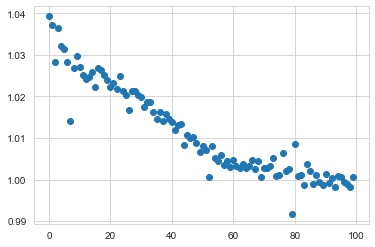

In [7385]:
plt.scatter(epochs, avg_losses)

## Test data

In [7332]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

MyRNN(
  (rnn): RNN(2, 1, num_layers=3, batch_first=True)
  (fc): Linear(in_features=1, out_features=1, bias=False)
  (final): Tanh()
)

In [7386]:
test_data_loader = torch.utils.data.DataLoader(test_data_zip, batch_size=1, shuffle=False ,collate_fn=collate)

In [7387]:
losses = []
outputs = []
elos = []
for evals, elo in test_data_loader:
    #print("evals",evals.shape)
    evals = evals.to(device)
    elo = elo.to(device)
    output = model(evals)
    outputs.append(output.item())
    elos.append(elo.item())
    loss = criterion(output,elo)
    #print(f'Model prediction : {output} \n ELO : {elo} \n MSE : {loss}')
    losses.append(loss.item())
print(f'Average loss : {s.mean(losses)}')

Average loss : 1.8345279118930513


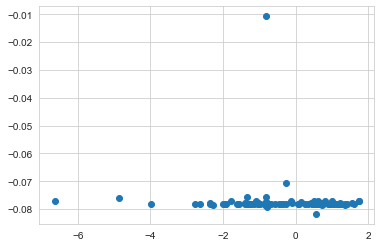

In [7388]:
plt.scatter(elos,outputs, alpha = 1)

In [7389]:
print(max(outputs))
print(min(outputs))

-0.01072134729474783
-0.08172544091939926


In [7390]:
class MyRNN(nn.Module):
    def __init__(self, input_size, hidden_size, no_layers):
        super(MyRNN, self).__init__()
        self.hidden_size = hidden_size
        self.no_layers = no_layers
        self.rnn = nn.RNN(input_size, hidden_size, no_layers, batch_first = True, bias = False)
        self.fc = nn.Linear(hidden_size,1, bias = False)

    def forward(self, x):
        # initial hidden state
        h0 = torch.rand(self.no_layers,x.size(0),self.hidden_size)

        out, _ = self.rnn(x,h0)
        #print(out) #return out
        out = out[:,-1,:]
        #print(out)
        out = self.fc(out)
        #print(out)
        m = nn.Sigmoid()
        out = m(out)
        return out
        # print("out: ",out)
        # print('RNN WEIGHTS: ',self.rnn.weight_ih_l0  )
        # print(self.fc.weight)
        #
        # #print("Count these...",out)
        # m = nn.Sigmoid()
        # out = m(out)
        # if x.size(0) == 1:
        #     return out[0]
        # else:
        #     return torch.squeeze(out)


In [7338]:
model = MyRNN(input_size, hidden_size, no_layers)

In [7339]:
d = [i*2/150**2 for i in range(132)]
sample_input = torch.tensor(d, dtype = torch.float32)
sample_input = sample_input.unsqueeze(1)
sample_input = sample_input.unsqueeze(0)
print(sample_input.shape)
print(model(sample_input))

torch.Size([1, 132, 1])


RuntimeError: input.size(-1) must be equal to input_size. Expected 2, got 1

In [ ]:
d = [i+1/132 for i in range(132)]
sample_input = torch.tensor(d, dtype = torch.float32)
sample_input = sample_input.unsqueeze(1)
sample_input = sample_input.unsqueeze(0)
print(sample_input.shape)

In [ ]:
print(model(sample_input))